## Feature Selection: Forward and Backward Feature Elimination

In this notebook, we will go through implementing Wrapper Models for feature Selection. We will work on a  Linear Regression problem.

In [ ]:
#### import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 1- Data 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Feature_selection/cancer-mortality-rate.csv', index_col=0)
data.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,avgAnnCount-2,avgAnnCount-3,avgAnnCount-4,avgAnnCount-5,avgAnnCount-6,avgAnnCount-7,avgAnnCount-8,avgAnnCount-9,...,PctBlack-2,PctBlack-3,PctBlack-4,PctBlack-5,PctBlack-6,PctBlack-7,PctBlack-8,PctBlack-9,PctAsian-2,PctAsian-3,PctAsian-4,PctAsian-5,PctAsian-6,PctAsian-7,PctAsian-8,PctAsian-9,PctOtherRace-2,PctOtherRace-3,PctOtherRace-4,PctOtherRace-5,PctOtherRace-6,PctOtherRace-7,PctOtherRace-8,PctOtherRace-9,PctMarriedHouseholds-2,PctMarriedHouseholds-3,PctMarriedHouseholds-4,PctMarriedHouseholds-5,PctMarriedHouseholds-6,PctMarriedHouseholds-7,PctMarriedHouseholds-8,PctMarriedHouseholds-9,BirthRate-2,BirthRate-3,BirthRate-4,BirthRate-5,BirthRate-6,BirthRate-7,BirthRate-8,BirthRate-9
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,39.3,36.9,41.7,2.54,52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,1951609.0,2.726398e+09,3.808778e+12,5.320862e+15,7.433245e+18,1.038424e+22,1.450679e+25,2.026598e+28,...,6.732615,17.469307,45.328106,117.614122,305.176694,791.850616,2054.637228,5331.225430,23.250306,112.109653,540.576725,2606.583721,12568.574225,60603.868891,292223.195619,1.409058e+06,3.398413,6.264902,11.549212,21.290724,39.248992,72.354674,133.384289,245.891073,2793.764757,147667.442010,7.805122e+06,4.125481e+08,2.180567e+10,1.152562e+12,6.091992e+13,3.219988e+15,37.440093,229.089604,1401.760576,8577.136107,52482.046553,321128.774915,1.964933e+06,1.202309e+07
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,33.0,32.2,33.7,2.34,44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,29929.0,5.177717e+06,8.957450e+08,1.549639e+11,2.680875e+13,4.637914e+15,8.023592e+17,1.388081e+20,...,0.939160,0.910142,0.882021,0.854768,0.828358,0.802764,0.777961,0.753923,5.045561,11.333503,25.457684,57.183879,128.448293,288.524742,648.093677,1.455769e+03,13.997711,52.370359,195.935921,733.065158,2742.654452,10261.234432,38390.885152,143633.796942,2058.663796,93406.723998,4.238097e+06,1.922930e+08,8.724816e+09,3.958667e+11,1.796146e+13,8.149565e+14,18.775717,81.356978,352.527560,1527.535610,6618.957797,28680.576760,1.242757e+05,5.384984e+05
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,45.0,44.0,45.8,2.62,54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,10404.0,1.061208e+06,1.082432e+08,1.104081e+10,1.126162e+12,1.148686e+14,1.171659e+16,1.195093e+18,...,0.547117,0.404688,0.299337,0.221411,0.163772,0.121138,0.089602,0.066277,0.217061,0.101128,0.047116,0.021951,0.010227,0.004765,0.002220,1.034235e-03,7.547978,20.736999,56.971967,156.522407,430.023135,1181.427634,3245.805027,8917.389410,2964.243692,161387.857618,8.786741e+06,4.783929e+08,2.604604e+10,1.418073e+12,7.720681e+13,4.203515e+15,13.909079,51.873742,193.462489,721.515996,2690.885118,10035.623263,3.742773e+04,1.395863e+05
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,42.8,42.2,43.4,2.52,52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,182329.0,7.785448e+07,3.324386e+10,1.419513e+13,6.061321e+15,2.588184e+18,1.105155e+21,4.719010e+23,...,0.612503,0.479361,0.375160,0.293610,0.229787,0.179837,0.140745,0.110151,1.348754,1.566387,1.819137,2.112671,2.453569,2.849473,3.309260,3.843238e+00,1.856796,2.530151,3.447693,4.697975,6.401664,8.723184,11.886587,16.197177,2603.194940,132818.948317,6.776624e+06,3.457536e+08,1.764087e+10,

In [ ]:
data.shape

(3047, 280)

### 2- Data Preprocessing

In [ ]:
#Check Nan values
for col in data.columns:
    if data[col].isna().sum()!=0:
        print(f"Col: {col}, Number of nan value: {data[col].isna().sum()}")

Col: PctSomeCol18_24, Number of nan value: 2285
Col: PctEmployed16_Over, Number of nan value: 152
Col: PctPrivateCoverageAlone, Number of nan value: 609
Col: PctSomeCol18_24-2, Number of nan value: 2285
Col: PctSomeCol18_24-3, Number of nan value: 2285
Col: PctSomeCol18_24-4, Number of nan value: 2285
Col: PctSomeCol18_24-5, Number of nan value: 2285
Col: PctSomeCol18_24-6, Number of nan value: 2285
Col: PctSomeCol18_24-7, Number of nan value: 2285
Col: PctSomeCol18_24-8, Number of nan value: 2285
Col: PctSomeCol18_24-9, Number of nan value: 2285
Col: PctEmployed16_Over-2, Number of nan value: 152
Col: PctEmployed16_Over-3, Number of nan value: 152
Col: PctEmployed16_Over-4, Number of nan value: 152
Col: PctEmployed16_Over-5, Number of nan value: 152
Col: PctEmployed16_Over-6, Number of nan value: 152
Col: PctEmployed16_Over-7, Number of nan value: 152
Col: PctEmployed16_Over-8, Number of nan value: 152
Col: PctEmployed16_Over-9, Number of nan value: 152
Col: PctPrivateCoverageAlone-2,

In [ ]:
for col in data.columns:
    if data[col].isna().sum()!=0:
        data[col][data[col].isna()] = data[col].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y = data['TARGET_deathRate']
X = data.drop(columns=['TARGET_deathRate'])
normalized_X = (X - X.mean()) / X.std()

X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, y, test_size = .2, random_state=123)

### 3- Fit a LR model on all features

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_pred, Y_test)))

RMSE:  112255.8675969501


In [ ]:
kf = KFold(n_splits=5, random_state= 42)
print(kf)  

# KFold training helper function
def KFold_train(model, X, Y, kf):
    scores = []
    for train_index, val_index in kf.split(X): #we split the train to KFold cross validate
        x_train, x_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]
        model.fit(x_train, y_train)
        pred_y = model.predict(x_val)
        scores.append(mean_squared_error(y_val, pred_y)**.5)
    
    return np.mean(np.array(scores))

KFold(n_splits=5, random_state=42, shuffle=False)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### Feature selection greedy methods

In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2437, 279), (610, 279), (2437,), (610,))

In [ ]:
#features =  [ c for c in data.columns if c not in ['TARGET_deathRate']]


In [ ]:
X.head()

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,PctHS18_24,PctSomeCol18_24,PctBachDeg18_24,PctHS25_Over,PctBachDeg25_Over,PctEmployed16_Over,PctUnemployed16_Over,PctPrivateCoverage,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,avgAnnCount-2,avgAnnCount-3,avgAnnCount-4,avgAnnCount-5,avgAnnCount-6,avgAnnCount-7,avgAnnCount-8,avgAnnCount-9,avgDeathsPerYear-2,...,PctBlack-2,PctBlack-3,PctBlack-4,PctBlack-5,PctBlack-6,PctBlack-7,PctBlack-8,PctBlack-9,PctAsian-2,PctAsian-3,PctAsian-4,PctAsian-5,PctAsian-6,PctAsian-7,PctAsian-8,PctAsian-9,PctOtherRace-2,PctOtherRace-3,PctOtherRace-4,PctOtherRace-5,PctOtherRace-6,PctOtherRace-7,PctOtherRace-8,PctOtherRace-9,PctMarriedHouseholds-2,PctMarriedHouseholds-3,PctMarriedHouseholds-4,PctMarriedHouseholds-5,PctMarriedHouseholds-6,PctMarriedHouseholds-7,PctMarriedHouseholds-8,PctMarriedHouseholds-9,BirthRate-2,BirthRate-3,BirthRate-4,BirthRate-5,BirthRate-6,BirthRate-7,BirthRate-8,BirthRate-9
0,1397.0,469,489.8,61898,260131,11.2,499.748204,39.3,36.9,41.7,2.54,52.5,11.5,39.5,42.100000,6.9,23.2,19.6,51.9,8.0,75.1,48.453774,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,1951609.0,2.726398e+09,3.808778e+12,5.320862e+15,7.433245e+18,1.038424e+22,1.450679e+25,2.026598e+28,219961,...,6.732615,17.469307,45.328106,117.614122,305.176694,791.850616,2054.637228,5331.225430,23.250306,112.109653,540.576725,2606.583721,12568.574225,60603.868891,292223.195619,1.409058e+06,3.398413,6.264902,11.549212,21.290724,39.248992,72.354674,133.384289,245.891073,2793.764757,147667.442010,7.805122e+06,4.125481e+08,2.180567e+10,1.152562e+12,6.091992e+13,3.219988e+15,37.440093,229.089604,1401.760576,8577.136107,52482.046553,321128.774915,1.964933e+06,1.202309e+07
1,173.0,70,411.6,48127,43269,18.6,23.111234,33.0,32.2,33.7,2.34,44.5,6.1,22.4,64.000000,7.5,26.0,22.7,55.9,7.8,70.2,53.800000,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,29929.0,5.177717e+06,8.957450e+08,1.549639e+11,2.680875e+13,4.637914e+15,8.023592e+17,1.388081e+20,4900,...,0.939160,0.910142,0.882021,0.854768,0.828358,0.802764,0.777961,0.753923,5.045561,11.333503,25.457684,57.183879,128.448293,288.524742,648.093677,1.455769e+03,13.997711,52.370359,195.935921,733.065158,2742.654452,10261.234432,38390.885152,143633.796942,2058.663796,93406.723998,4.238097e+06,1.922930e+08,8.724816e+09,3.958667e+11,1.796146e+13,8.149565e+14,18.775717,81.356978,352.527560,1527.535610,6618.957797,28680.576760,1.242757e+05,5.384984e+05
2,102.0,50,349.7,49348,21026,14.6,47.560164,45.0,44.0,45.8,2.62,54.2,24.0,36.6,40.977034,9.5,29.0,16.0,45.9,7.0,63.7,43.500000,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,10404.0,1.061208e+06,1.082432e+08,1.104081e+10,1.126162e+12,1.148686e+14,1.171659e+16,1.195093e+18,2500,...,0.547117,0.404688,0.299337,0.221411,0.163772,0.121138,0.089602,0.066277,0.217061,0.101128,0.047116,0.021951,0.010227,0.004765,0.002220,1.034235e-03,7.547978,20.736999,56.971967,156.522407,430.023135,1181.427634,3245.805027,8917.389410,2964.243692,161387.857618,8.786741e+06,4.783929e+08,2.604604e+10,1.418073e+12,7.720681e+13,4.203515e+15,13.909079,51.873742,193.462489,721.515996,2690.885118,10035.623263,3.742773e+04,1.395863e+05
3,427.0,202,430.4,44243,75882,17.1,342.637253,42.8,42.2,43.4,2.52,52.7,20.2,41.2,36.100000,2.5,31.6,9.3,48.3,12.1,58.4,40.300000,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,182329.0,7.785448e+07,3.324386e+10,1.419513e+13,6.061321e+15,2.588184e+18,1.105155e+21,4.719010e+23,40804,...,0.612503,0.479361,0.375160,0.293610,0.229787,0.179837,0.140745,0.110151,1.348754,1.566387,1.819137,2.112671,2.453569,2.849473,3.309260,3.843238e+00,1.856796,2.530151,3.447693,4.697975,6.401664,8.723184,11.886587,16.197177,2603.194940,132818.948

## 4 -  Forward Search
<img src='forward.png'>

In [ ]:
def forward_search(model, K, X, Y):
    
    rmse_losses = []
    best_losses = []
    set_features = []
    all_scores = []
    
    ### get all the features of the data
    features =  [ c  for c in X.columns]
    i = 1 # this index handles the case of one feature where reshaping is needed (do not care about it)
    while len(set_features) <= K:
        rmse_losses = []

        for feature in features:

            # Extract X with the subset of features
            new_feature = [feature] + set_features

            # Extract X with the subset of new features
            new_data = X[new_feature]

            #split the new_data in train and validation(test_size = 20%)
            x_train, x_val, y_train, y_val = train_test_split(new_data,Y,test_size=0.2,random_state=42)

            if i == 1:
              # x_train=np.array(x_train)
              # x_val=np.array(x_val)


              x_train = x_train.values.reshape(-1, 1)
              x_val = x_val.values.reshape(-1, 1)

                

            #Cross validation using the KFold_train function
            scores= KFold_train(model,new_data,Y,kf)
            
            # Fit the model on the training set
            model.fit(x_train,y_train) ## Replace with your code
            
            #Make Prediction on the validation set
            ypred = model.predict(x_val) 

            #Calculate the RMSE on the validation set
            rmse_loss = np.sqrt(mean_squared_error(y_val,ypred))


            rmse_losses.append(rmse_loss)
        
        i += 1
        #select features that give the best RMSE
        present_best_feature = features[np.argmin(rmse_losses)]
        
        #remove that present best feature from the initial set of input features, we will not include it again
        features.remove(present_best_feature)
        #add the present best feature to set_features
        set_features.append(present_best_feature) ### replace with your code###
        
        all_scores.append(np.mean(scores))
        best_losses.append(np.min(rmse_losses))
        print('K=',len(set_features),':',set_features, ' || RMSE: ', np.min(rmse_losses) )
    return set_features,all_scores, best_losses

In [ ]:
### Let us fix a value of K, in this case k = d**.5
K = int(X.shape[1]**.5)
lr = LinearRegression()
best_features, scores, best_losses = forward_search(lr, K, X_train, Y_train)

K= 1 : ['povertyPercent']  || RMSE:  24.777151109330987
K= 2 : ['povertyPercent', 'incidenceRate']  || RMSE:  23.30397611342249
K= 3 : ['povertyPercent', 'incidenceRate', 'PctBachDeg25_Over']  || RMSE:  21.656996516272564
K= 4 : ['povertyPercent', 'incidenceRate', 'PctBachDeg25_Over', 'PctSomeCol18_24-9']  || RMSE:  21.457807799749624
K= 5 : ['povertyPercent', 'incidenceRate', 'PctBachDeg25_Over', 'PctSomeCol18_24-9', 'PctOtherRace']  || RMSE:  21.259826396775377
K= 6 : ['povertyPercent', 'incidenceRate', 'PctBachDeg25_Over', 'PctSomeCol18_24-9', 'PctOtherRace', 'PercentMarried-9']  || RMSE:  21.130718660787046
K= 7 : ['povertyPercent', 'incidenceRate', 'PctBachDeg25_Over', 'PctSomeCol18_24-9', 'PctOtherRace', 'PercentMarried-9', 'PctPublicCoverageAlone-3']  || RMSE:  21.02854500077297
K= 8 : ['povertyPercent', 'incidenceRate', 'PctBachDeg25_Over', 'PctSomeCol18_24-9', 'PctOtherRace', 'PercentMarried-9', 'PctPublicCoverageAlone-3', 'PctHS25_Over']  || RMSE:  20.923233758633252
K= 9 : [

Best Features from Forward Search:  ['povertyPercent', 'incidenceRate', 'PctBachDeg25_Over', 'PctSomeCol18_24-9', 'PctOtherRace', 'PercentMarried-9', 'PctPublicCoverageAlone-3', 'PctHS25_Over', 'PctWhite-6', 'BirthRate-2', 'MedianAgeFemale-9', 'PctHS18_24-4', 'PctSomeCol18_24-8', 'PercentMarried-8', 'PctUnemployed16_Over', 'popEst2015-6', 'PctMarriedHouseholds']


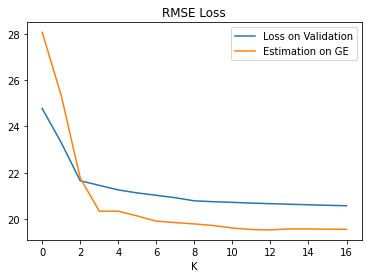

In [ ]:
print('Best Features from Forward Search: ',best_features)
plt.plot(best_losses, label='Loss on Validation')
plt.plot(scores, label='Estimation on GE')
plt.xlabel('K')
plt.title('RMSE Loss')
plt.legend()

In [ ]:
### Make prediction on our Test Set with the new set of features
test_pred = lr.predict(X_test[best_features])

### Compute the RMSE
rmse = np.sqrt(mean_squared_error(Y_test,test_pred))
print('RMSE Test Loss: ', rmse)

RMSE Test Loss:  38.537854747483095


## 5-Backward Search

Backward search
starts off with F = {1, . . . , d} as the set of all features
1. Train the model with all the features

2. repeatedly delete features one at a time (evaluating single-feature deletions in a similar manner to how forward search evaluates single-feature additions) until F = ∅

In [ ]:
def backward_search(model, X, Y, K):
    
    ### get the features of the data
    features = X.columns.tolist()
    
    rmse_losses = []
    best_losses = []
    best_features = []
    subset_feature = features
    all_scores = []
    
    while len(subset_feature) > K:
        all_poss_features = []
        rmse_losses = []
        for feature in features:
            subset_feature = features.copy()
            subset_feature.remove(feature)

            # Extract X with the subset of new features
            new_data = X[subset_feature] 
            
            #split the new_data in train and validation(test_size = 20%)
            x_train, x_val, y_train, y_val = train_test_split(new_data,Y,test_size=0.2,random_state=42)

            y_train = y_train.values.reshape(-1, 1)
            y_val = y_val.values.reshape(-1, 1)

            #Cross validation using the KFold_train function
            scores= KFold_train(model,x_train,x_train,kf)
            
             # Fit the model on the training set
            model.fit(x_train,y_train) ## Replace with your code
            
            #Make Prediction on the validation set
            ypred = model.predict(x_val)  

            #Calculate the RMSE on the validation set
            rmse_loss = np.sqrt(mean_squared_error(y_val,ypred))

            rmse_losses.append(rmse_loss)
            all_poss_features.append(subset_feature)
    
        #Remove the feature f_i that, when eliminated, gives the best RMSE so far.
        #ie if F-{f_i} gives the best RMSE so far, f_i will not be considered again on next iterations
        feature_to_eliminate = subset_feature[np.argmax(rmse_losses)]
        
        #remove that feature from the initial set of input features
        subset_feature.remove(feature_to_eliminate) ### replace with your code###
          
        best_features.append(all_poss_features[np.argmin(rmse_losses)])
        all_scores.append(np.mean(scores))
        best_losses.append(np.min(rmse_losses))
        print('K=',len(set_features),':',set_features, ' || RMSE: ', np.min(rmse_losses) )
    return best_features,all_scores, best_losses

In [ ]:
K = 271
lr = LinearRegression()
best_features, best_losses = backward_search(lr, X_train, Y_train, K)

NameError: ignored

In [ ]:
print('Best Features from Backward Search: ', best_features)
plt.plot(best_losses, label='Loss on Validation')
plt.plot(scores, label='Estimation on G.E.')
plt.xlabel('K')
plt.label('RMSE Loss')
plt.legend()

In [ ]:
### Make prediction on our Test Set with the new set of features
test_pred = None

### Compute the RMSE
rmse = None
print('RMSE Test Loss: ', rmse)

<b>Missing Value Ratio</b> is a filter method for Feature Selection that drops all the features that have a number of missing values greater than a certain threshold. 
Can you implement it using this previous dataset?